## Load libraries

In [1]:
import multitaper.mtspec as mtspec
import multitaper.mtcross as mtcross
import numpy as np
import matplotlib.pyplot as plt


## Sediment Core data

Load sediment core data
Number of points and dt  156 4930
Create MTSPEC class for your data
Type of psd  <class 'multitaper.mtspec.mtspec'>


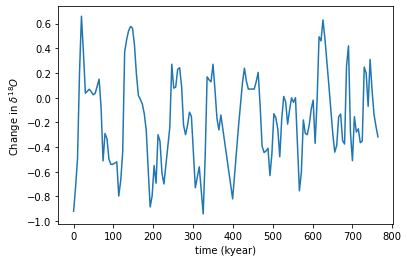

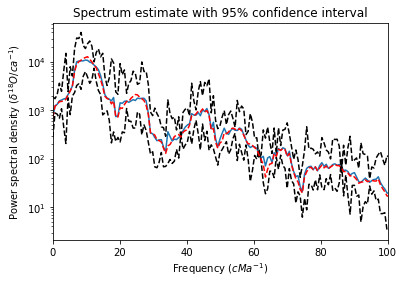

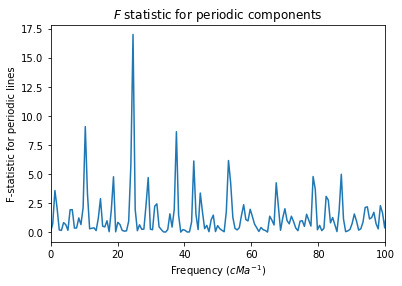

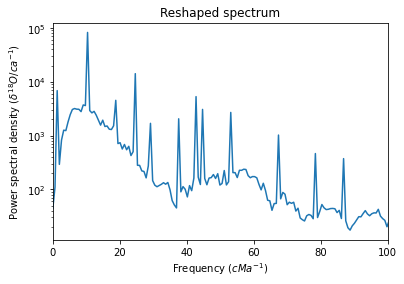

In [2]:
#------------------------------------------------
# Define desired parameters
#------------------------------------------------
nw    = 3.5
kspec = 5 

#------------------------------------------------
# Load the data
#------------------------------------------------

x    = np.loadtxt('../data/v22_174_series.dat')
npts = np.shape(x)[0]
dt   = 4930
t    = np.arange(npts)*dt

print('Load sediment core data')
print('Number of points and dt ', npts,dt)

fig = plt.figure(1)
ax  = fig.add_subplot()
ax.plot(t/1000,x)
ax.set_xlabel('time (kyear)')
ax.set_ylabel(r'Change in $\delta^{18}O$')

#------------------------------------------------
# Get MTSPEC
#     Get reshape spectrum with F test
#     Get confidence intervals
#     Get QI spectrum
#------------------------------------------------

print('Create MTSPEC class for your data')
psd = mtspec.mtspec(x,nw,kspec,dt,iadapt=0)
print('Type of psd ', type(psd))

#------------------------------------------------
# Reshape spectrum
#------------------------------------------------
F,p = psd.ftest()
respec, spec_noline, yk, sline = psd.reshape(fcrit=0.90,p=p)
#------------------------------------------------
# Confidence intervals
#------------------------------------------------
spec_ci = psd.jackspec()
#------------------------------------------------
# QI inverse spectrum
#------------------------------------------------
qispec  = psd.qiinv()[0]

# Plot only positive frequencies
freq ,spec               = psd.rspec()
freq,qispec,spec_ci      = psd.rspec(qispec,spec_ci)
freq,respec,spec_noline  = psd.rspec(respec,spec_noline)
F = F[0:psd.nf]


fig = plt.figure(2)
ax  = fig.add_subplot()
ax.semilogy(freq*1e6,spec)
ax.semilogy(freq*1e6,spec_ci,'k--')
ax.semilogy(freq*1e6,qispec,'r--')
ax.set_title('Spectrum estimate with 95% confidence interval')
ax.set_xlim(0, 100)
ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')

fig = plt.figure(3)
ax  = fig.add_subplot()
ax.plot(freq*1e6,F)
ax.set_xlim(0,100)
ax.set_title(r'$F$ statistic for periodic components')
ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
ax.set_ylabel(r'F-statistic for periodic lines')
#plt.ylim(-0.5,14.5)

fig = plt.figure(4)
ax  = fig.add_subplot()
ax.semilogy(freq*1e6,respec)
ax.set_xlim(0,100)
ax.set_title(r'Reshaped spectrum')
ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')
#plt.ylim(-0.5,14.5)

plt.show()




## Seismic ambient noise

----- Calculating Sine Multitaper ------
----------------------------------------
------ Calculating Thomson Multitaper --------
----------------------------------------------
------ Calculating Quadratic Multitaper ------
----------------------------------------------


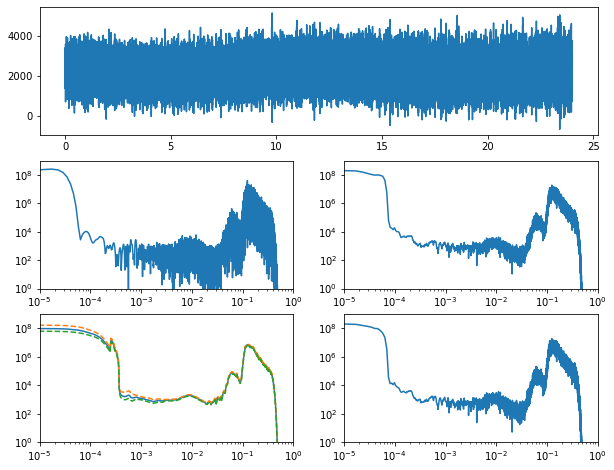

In [3]:
#------------------------------------------------
# Define desired parameters
#------------------------------------------------

nw    = 4.0
kspec = 7

#------------------------------------------------
# Load the data
#------------------------------------------------

x = np.loadtxt('../data/PASC.dat')
npts = np.shape(x)[0]
dt = 1.0 
t  = np.arange(npts)*dt

#------------------------------------------------
# Get MTSINE
#     Get sine psd
#------------------------------------------------

print('----- Calculating Sine Multitaper ------')
sine_psd    = mtspec.mtsine(x,ntap=0,ntimes=2,fact=1.0,dt=dt)
print('----------------------------------------')
#------------------------------------------------
# Get MTSPEC
#     Get spectrum
#     Get QI spectrum
#------------------------------------------------

print('------ Calculating Thomson Multitaper --------')
psd    = mtspec.mtspec(x,nw,kspec,dt,iadapt=0)
print('----------------------------------------------')
print('------ Calculating Quadratic Multitaper ------')
qispec = psd.qiinv()[0]
print('----------------------------------------------')

# Plot only positive frequencies
freq ,spec       = psd.rspec()
freq,qispec      = psd.rspec(qispec)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(3,1,1)
ax.plot(t/3600,x)
ax = fig.add_subplot(3,2,3)
ax.loglog(freq,psd.sk[0:psd.nf,0])
ax.set_ylim(1e0,1e9)
ax.set_xlim(1e-5,1e0)
ax = fig.add_subplot(3,2,4)
ax.loglog(freq,spec)
ax.set_ylim(1e0,1e9)
ax.set_xlim(1e-5,1e0)
ax = fig.add_subplot(3,2,5)
ax.loglog(sine_psd.freq,sine_psd.spec)
ax.loglog(sine_psd.freq,sine_psd.err,'--')
ax.set_ylim(1e0,1e9)
ax.set_xlim(1e-5,1e0)
ax = fig.add_subplot(3,2,6)
ax.loglog(freq,qispec)
ax.set_ylim(1e0,1e9)
ax.set_xlim(1e-5,1e0)

plt.show()


## Transfer functions in electromagnetics

### Function to estimate average admittance $c$

In [4]:
def Qi(nf,trf,cohe,freq):

    Qi   = trf[1:nf]
    cohe = cohe[1:nf]
    wt   = np.zeros((nf-1),dtype=float)
    per  = freq[1:nf]
    per  = 1.0/per
    lper = np.log10(per)

    #-------------------------------------
    #  Compute Qi and wt
    #-------------------------------------

    for i in range(nf-1):
        if (cohe[i]>= 0.6):
            wt[i] = 1.0/np.sqrt(1.0-cohe[i])
        else:
            wt[i] = 0.0

    #-------------------------------------------
    #  Band averaging 
    #     (as Constable and Constable (2004)
    #-------------------------------------------

    avper = np.zeros(10,dtype=float)
    avper[0]  = 21330.0 
    avper[1]  = 41410.0 
    avper[2]  = 74400.0 
    avper[3]  = 185100.0 
    avper[4]  = 348000.0
    avper[5]  = 697800.0
    avper[6]  = 1428000.0
    avper[7]  = 2674000.0 
    avper[8]  = 4593000.0 
    avper[9]  = 11810000.0

    avper = np.log10(avper)

    travg = np.zeros(10,dtype=complex)
    for i in range(10):
        per2loc = np.abs(lper-avper[i])
        iloc1 = np.where(per2loc<=0.1)
        iloc  = np.array(iloc1[0])
        nloc  = len(iloc) 
        if (nloc<1):
            continue

        swt = 0.0
        for k in range(nloc):
           k2 = iloc[k]
           travg[i] = travg[i] + wt[k2]*Qi[k2]
           swt      = swt + wt[k2]
        travg[i] = travg[i]/swt

    cavg = 6378. * (1. - 2.*travg) / (2.*(1.+travg)) 

    return avper, cavg
 


npts, dt  4458 3600.0
----- Sine cross spectrum -------
----- MT cross spectrum -------


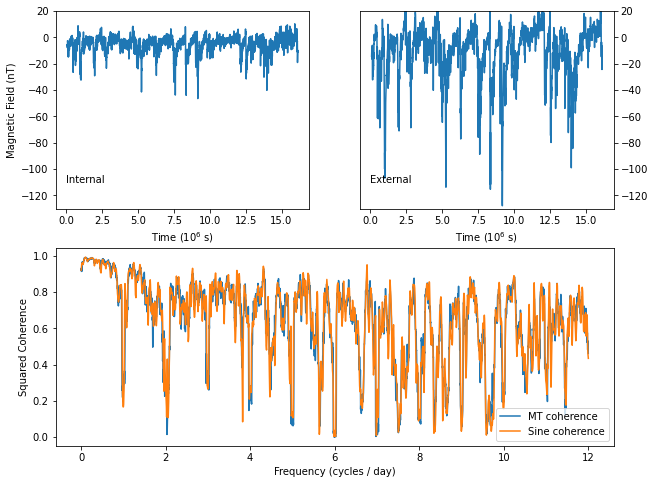

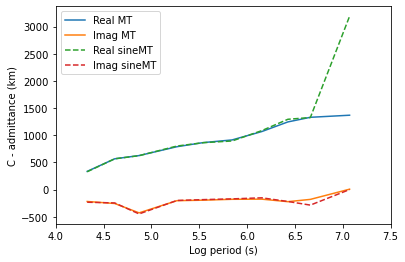

In [5]:
#------------------------------------------------
# Define desired parameters
#------------------------------------------------
nw    = 7.5
kspec = 12 

#------------------------------------------------
# Load the data
#------------------------------------------------

data = np.loadtxt('../data/asc_akima.dat')
t    = data[:,0]
x    = data[:,2]
y    = data[:,1]

npts = np.shape(x)[0]
dt   = t[1]-t[0] 
print('npts, dt ', npts,dt)

#------------------------------------------------
# Get MTSPEC
#     Get reshape spectrum with F test
#     Get confidence intervals
#     Get QI spectrum
#------------------------------------------------

print('----- Sine cross spectrum -------')
Sxy  = mtcross.sinecross(x,y,ntap=10,dt=dt)
avper, sine_cavg = Qi(Sxy.nf,Sxy.trf,Sxy.cohe,Sxy.freq)

print('----- MT cross spectrum -------')
Pxy  = mtcross.mtcross(x,y,nw,kspec,dt)
avper, cavg = Qi(Pxy.nf,Pxy.trf,Pxy.cohe,Pxy.freq)

fig = plt.figure(1,figsize=(10,8))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(t/1e6,x)
ax1.set_ylim(-130, 20)
ax1.set_ylabel('Magnetic Field (nT)')
ax1.set_xlabel(r'Time ($10^6$ s)')
ax2 = fig.add_subplot(2,2,2)
ax2.plot(t/1e6,y)
ax2.set_ylim(-130, 20)
ax2.set_xlabel(r'Time ($10^6$ s)')
ax2.yaxis.tick_right()
ax3 = fig.add_subplot(2,2,(3,4))
ax3.plot(Pxy.freq[0:Pxy.nf]*86400,Pxy.cohe[0:Pxy.nf],
        label='MT coherence')
ax3.plot(Sxy.freq*86400,Sxy.cohe,label='Sine coherence')
ax3.set_ylabel(r'Squared Coherence')
ax3.set_xlabel(r'Frequency (cycles / day)')
ax3.legend()
ax1.text(0,-110,'Internal')
ax2.text(0,-110,'External')

fig = plt.figure(2)
ax = fig.add_subplot()
ax.plot(avper,np.real(cavg),label='Real MT')
ax.plot(avper,np.imag(cavg),label='Imag MT')
ax.plot(avper,np.real(sine_cavg),'--',label='Real sineMT')
ax.plot(avper,np.imag(sine_cavg),'--',label='Imag sineMT')
ax.set_xlim(4., 7.5)
ax.legend()
ax.set_ylabel(r'C - admittance (km)')
ax.set_xlabel(r'Log period (s)')
#plt.ylim(-750, 1800)

plt.show()


## Noise cross-correlation, coherence and deconvolution

----- Sine IRF calculation -------
----------------------------------
----- MT IRF calculation -------
----------------------------------


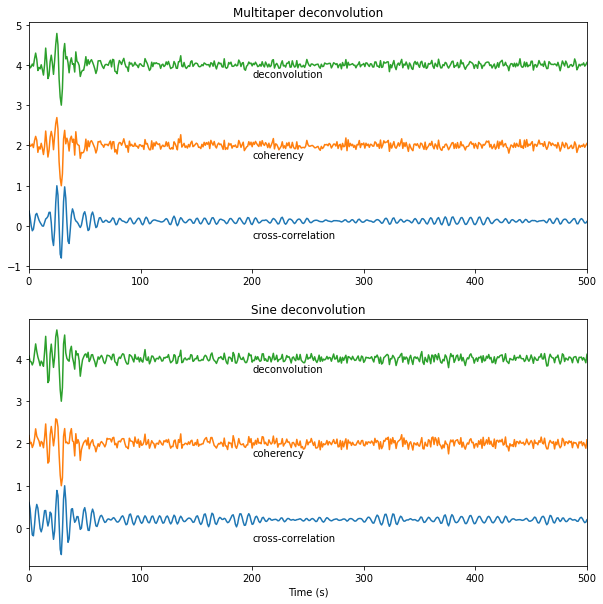

In [6]:

#------------------------------------------------
# Define desired parameters
#------------------------------------------------

dt    = 1
nw    = 4.0
kspec = 7
ntap  = 20 # number of sine tapers

#------------------------------------------------
# Load the data
#------------------------------------------------

x = np.loadtxt('../data/pasc.dat')
y = np.loadtxt('../data/ado.dat')

#------------------------------------------------
# Apply both sine and MT methods
#------------------------------------------------

print('----- Sine IRF calculation -------')
Sxy      = mtcross.sinecross(x,y,ntap=ntap,dt=dt)
Sxc, Sch, Sdcnv  = Sxy.mt_corr()
Si = np.linspace(Sxy.nf-500,Sxy.nf+500,1001,dtype=int)
St = Si-float(Sxy.nf)
print('----------------------------------')

print('----- MT IRF calculation -------')
Pxy  = mtcross.mtcross(x,y,nw,kspec,dt)
xcorr, dcohe, dconv  = Pxy.mt_corr()
i = np.linspace(Pxy.npts-500,Pxy.npts+500,1001,dtype=int)
t = i-float(Pxy.npts)
print('----------------------------------')

fig = plt.figure(1,figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(-t,xcorr[i]/np.max(np.abs(xcorr[i])))
ax1.plot(-t,dcohe[i]/np.max(np.abs(dcohe[i]))+2.0)
ax1.plot(-t,dconv[i]/np.max(np.abs(dconv[i]))+4.0)
ax1.set_title('Multitaper deconvolution')
ax1.text(200,-0.3,'cross-correlation')
ax1.text(200,2.0-0.3,'coherency')
ax1.text(200,4.0-0.3,'deconvolution')
ax1.set_xlim(0,500)

ax2 = fig.add_subplot(2,1,2)
ax2.plot(-St,Sxc[Si]/np.max(np.abs(Sxc[Si]))+0.0)
ax2.plot(-St,Sch[Si]/np.max(np.abs(Sch[Si]))+2.0)
ax2.plot(-St,Sdcnv[Si]/np.max(np.abs(Sdcnv[Si]))+4.0)
ax2.set_title('Sine deconvolution')
ax2.text(200,-0.3,'cross-correlation')
ax2.text(200,2.0-0.3,'coherency')
ax2.text(200,4.0-0.3,'deconvolution')
ax2.set_xlim(0,500)
ax2.set_xlabel('Time (s)')

plt.show()
